In [2]:
import torch
import numpy as np
import torch.nn as nn

if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev) 

In [3]:
features = torch.load('batched_data\\features_30min').to(device).to(torch.float32)
labels = torch.load('batched_data\\labels_30min').to(device).to(torch.float32)

In [4]:
print(features.shape)
print(labels.shape)

torch.Size([4750, 720, 2])
torch.Size([4750, 720])


In [5]:
class model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(model, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, 
                            bias=True, batch_first=True, dropout=0.0, 
                            bidirectional=False, proj_size=0, device=device, 
                            dtype=None)
        
        self.linear = nn.Linear(hidden_size, 1)
        self.softMax = nn.LogSoftmax(dim=-1)

        self.series_length = 720

    def forward(self, x, training=True):
        x, _ = self.lstm(x)

        if training:
            x = self.stack(x)
            x = self.linear(x)
            x = self.unstack(x)
        else:
            x = self.linear(x)

        #x = self.softMax(x)
        return x

    def stack(self, x):
        x = x.reshape(x.shape[0] * self.series_length, x.shape[-1])
        return x
    
    def unstack(self, x):
        x = x.reshape(x.shape[0] // self.series_length, self.series_length)
        return x

In [6]:
from torch import optim

inputSize = 2
hiddenSize = 50

lstm = model(inputSize, hiddenSize).to(device)
lossFunction = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr = 1e-3)


epoch:  1  loss:  5.133346647024155
epoch:  11  loss:  1.602201908826828
epoch:  21  loss:  1.430345892906189
epoch:  31  loss:  1.3976454734802246
epoch:  41  loss:  1.35539311170578
epoch:  51  loss:  1.3420295715332031
epoch:  61  loss:  1.329238548874855
epoch:  71  loss:  1.327729269862175
epoch:  81  loss:  1.3102490529417992
epoch:  91  loss:  1.3143060207366943
epoch:  101  loss:  1.298851653933525
epoch:  111  loss:  1.3176258504390717
epoch:  121  loss:  1.2837533131241798
epoch:  131  loss:  1.2815037295222282
epoch:  141  loss:  1.2846137583255768
epoch:  151  loss:  1.2650426551699638
epoch:  161  loss:  1.2823305651545525
epoch:  171  loss:  1.2721303328871727
epoch:  181  loss:  1.2599056214094162
epoch:  191  loss:  1.2588906660676003
epoch:  201  loss:  1.2463290318846703
epoch:  211  loss:  1.2586672976613045
epoch:  221  loss:  1.259585939347744
epoch:  231  loss:  1.2513087838888168
epoch:  241  loss:  1.2429105341434479
epoch:  251  loss:  1.2741683200001717
epoch:

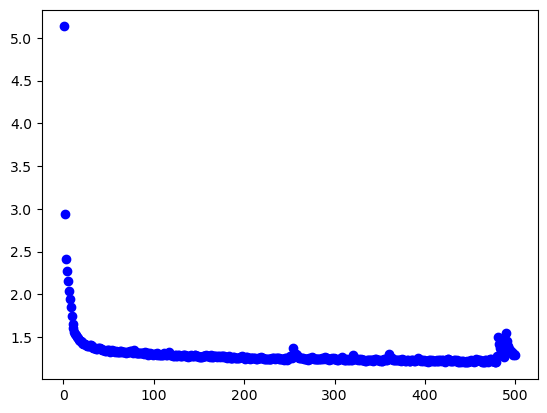

In [7]:
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

batch_size = 500
epochs = 500

train_dataset = TensorDataset(features, labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

for i in range(epochs):
    runningLoss = 0.0
    for x, y in train_dataloader:
        out = lstm(x)
    
        loss = lossFunction(out, y)
        
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        runningLoss += loss.detach().cpu().numpy()


    if i % 10 == 0:
        print("epoch: ", i + 1, " loss: ", runningLoss)
    plt.scatter(i + 1, runningLoss, color="b")
    


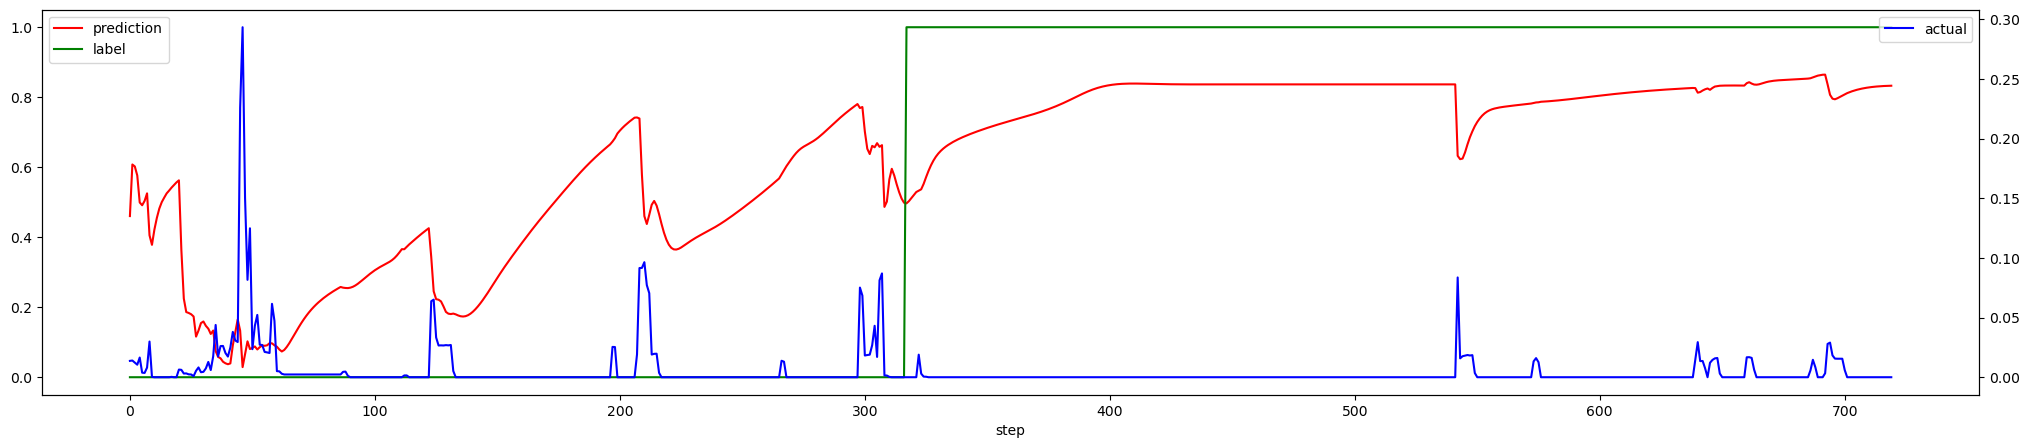

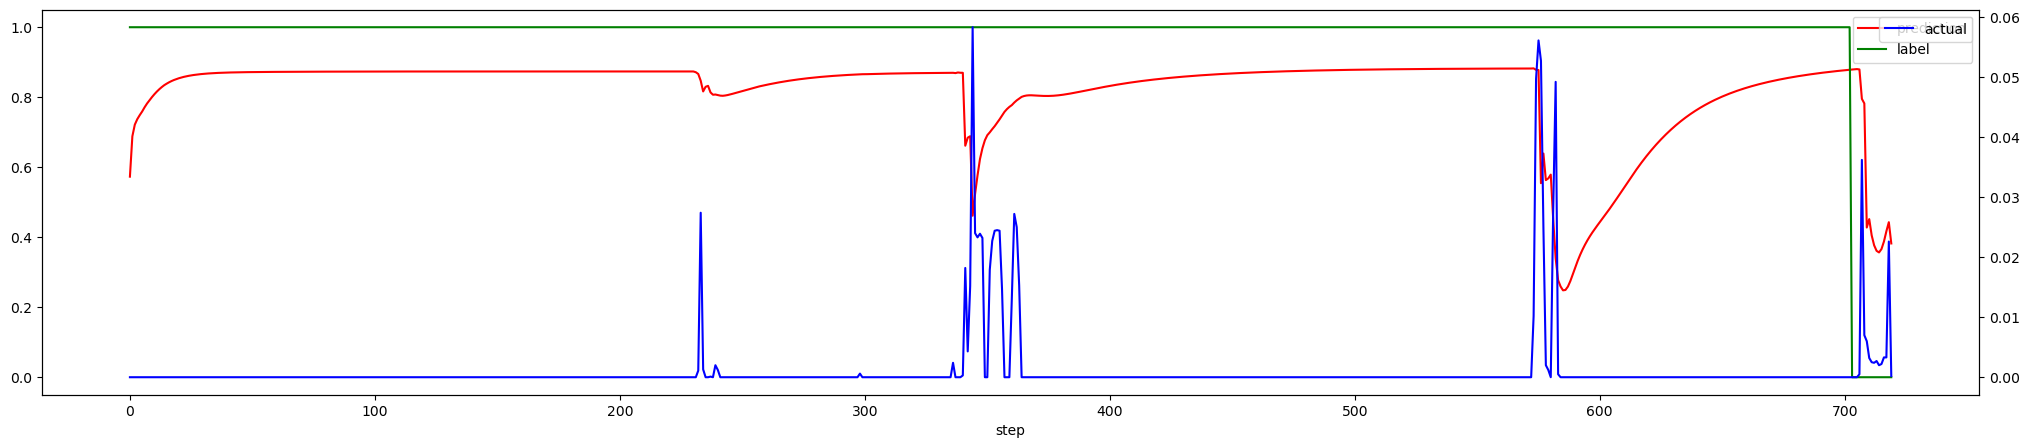

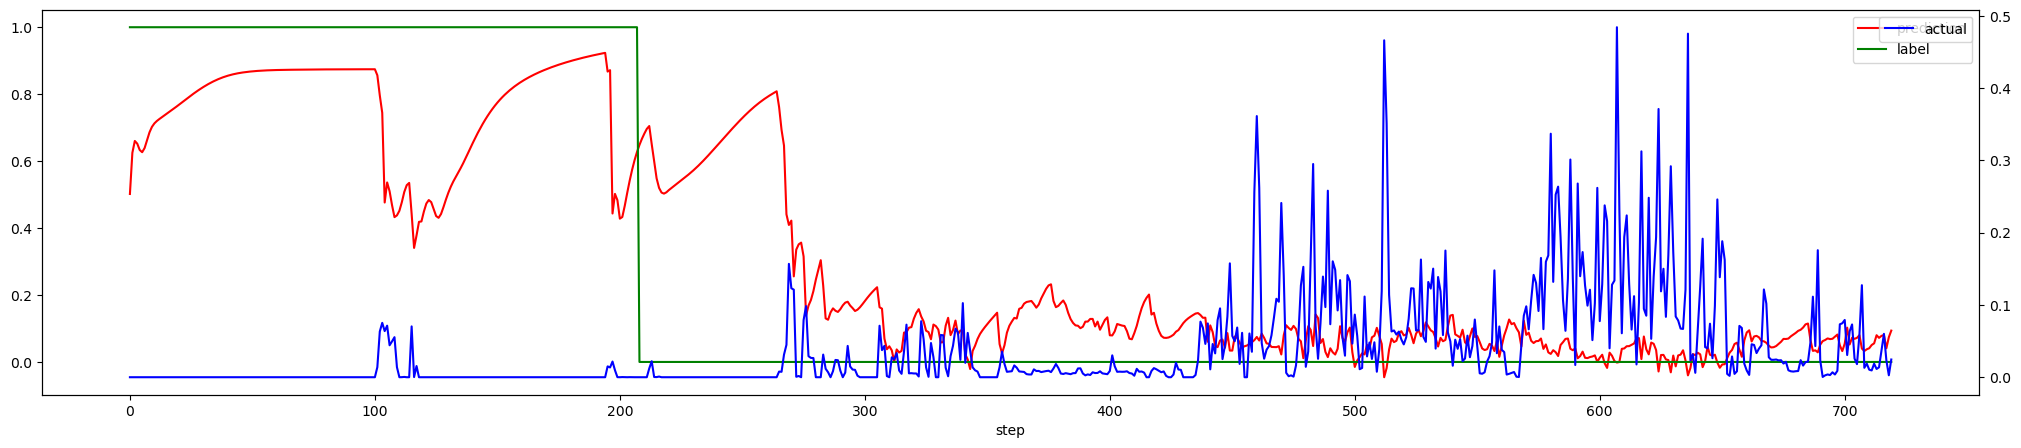

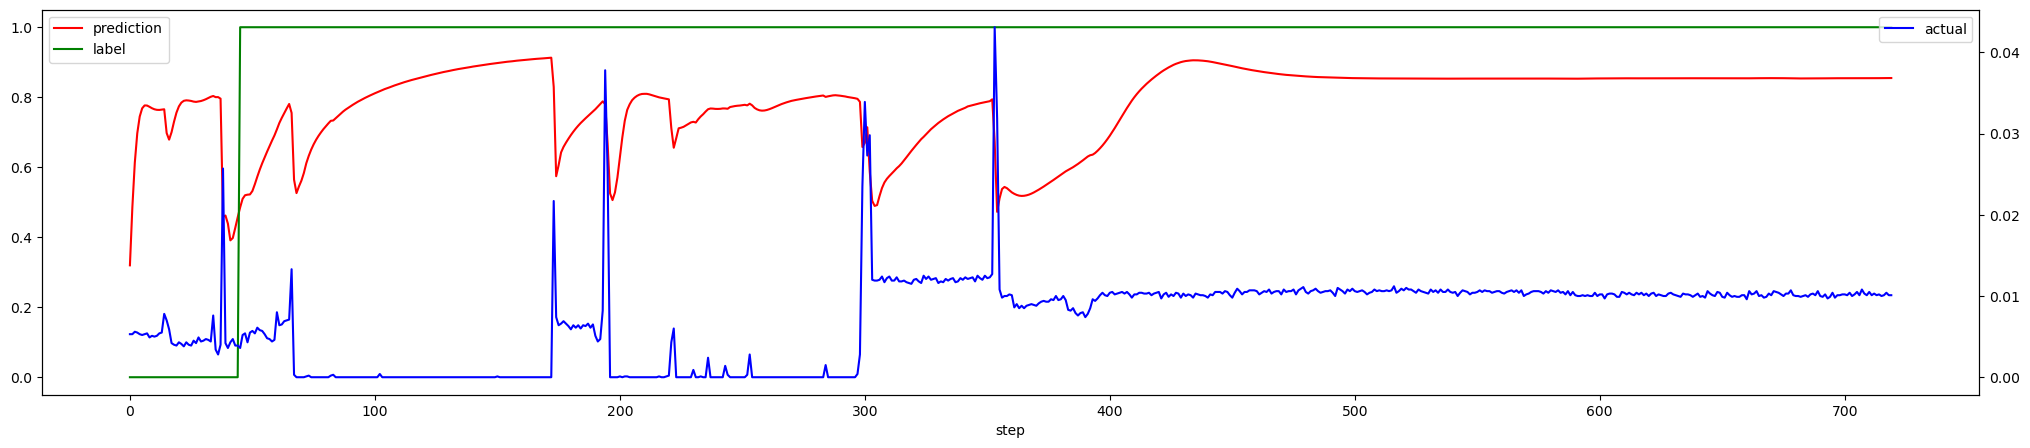

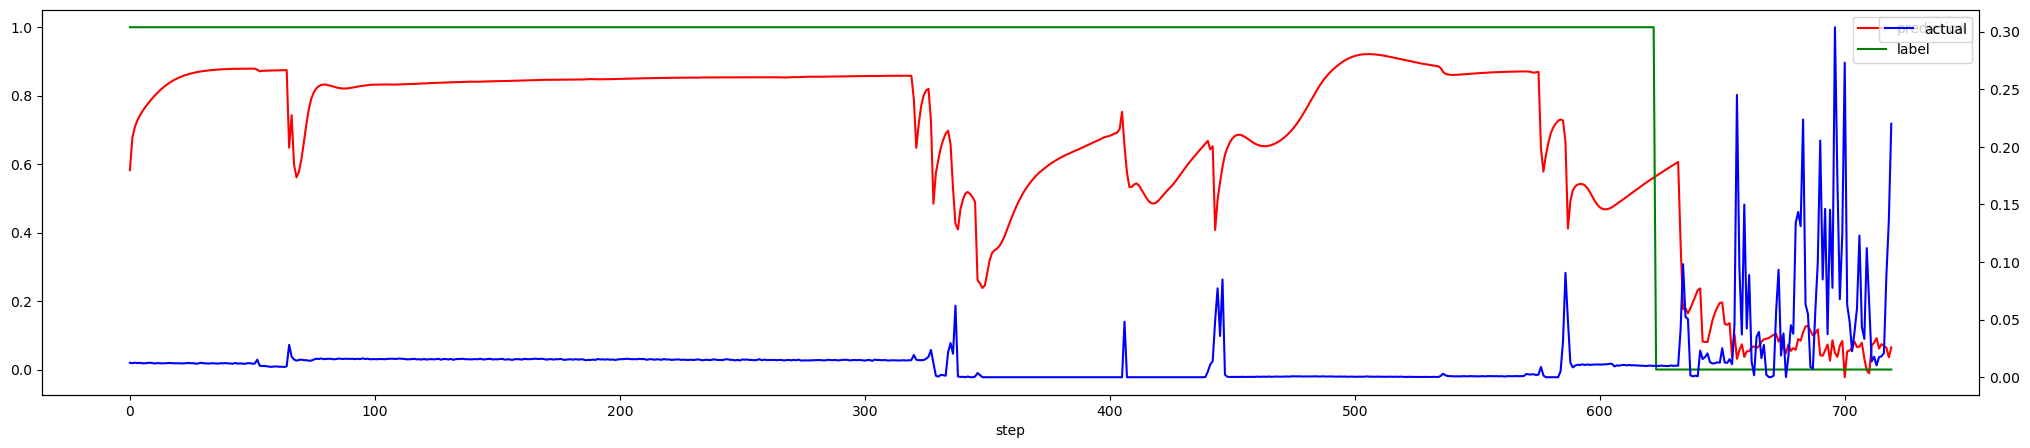

In [10]:
graph_actual = False

for i in range(5):
    fig, ax1 = plt.subplots()
    fig.set_size_inches(25, 5)
    ax2 = ax1.twinx()

    ax1.plot(lstm(features[i], training=False).cpu().detach().numpy(), color="r", label="prediction")
    ax1.set_xlabel("step")

    ax1.plot(labels[i].cpu().detach().numpy(), color="g", label="label")

    if graph_actual:
        ax2.plot(features[i, :, 1].cpu().detach().numpy(), color="b", label="actual")

    ax1.legend()
    ax2.legend()
    plt.show()